# Мониторинг инженерных установок

**Данные**: временной ряд мониторинга инженерных установок.

**Задача**: по показаниям датчиков, предсказать оставшийся срок полезного использования турбин самолетов

В этом ноутбуке предложено сравнение качества регрессии оставшегося срока полезного использования турбин самолетов на реальном и синтетическом наборе данных.


*Синтетический набор данных производится путем генерации временного ряда с помощью модели генеративно-состязательной сети  (timeGAN).*

## Загрузка библиотек

In [ ]:
!pip install tsgm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import numpy as np
import sklearn
import copy
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tsgm

## Чтение данных

In [ ]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [ ]:
train = pd.read_csv(('train_FD001.txt'), sep='\s+', header=None, names=col_names)

Набор данных FD001 содержит временные ряды из 21 датчика и 3 настройки по 100 единиц (турбовентиляторный двигатель). Каждый двигатель работает нормально в начале каждого временного ряда и выходит из строя в конце временного ряда. Каждая строка представляет собой снимок данных, полученных в течение одного операционного цикла.

In [ ]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Снижаем размерность данных с помощью метода главных компонент

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)

In [ ]:
newColumns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']

temp1 = pca.fit_transform(train.iloc[:, 2:])
#temp2 = pca.transform(test.iloc[:, 2:])

# Converting to Dataframes
temp1 = pd.DataFrame(temp1, columns = newColumns)
#temp2 = pd.DataFrame(temp2, columns = newColumns)

# Dropping Excess Data
train.drop(inplace = True, columns = train.columns[2:])
#test.drop(inplace = True, columns = test.columns[2:])

# Merging New Data
train = pd.merge(train, temp1, left_index=True, right_index=True)
#test = pd.merge(test, temp2, left_index=True, right_index=True)

In [ ]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_nr')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_nr',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [ ]:
tempRul = add_RUL_column(train)

In [ ]:
rul = tempRul.drop(['unit_nr', 'time_cycles', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5',
       'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10'], axis =1)

In [ ]:
rul.describe()

,RUL
count,20631.000000
mean,107.807862
std,68.880990
min,0.000000
25%,51.000000
50%,103.000000
75%,155.000000
max,361.000000


Корреляция данных

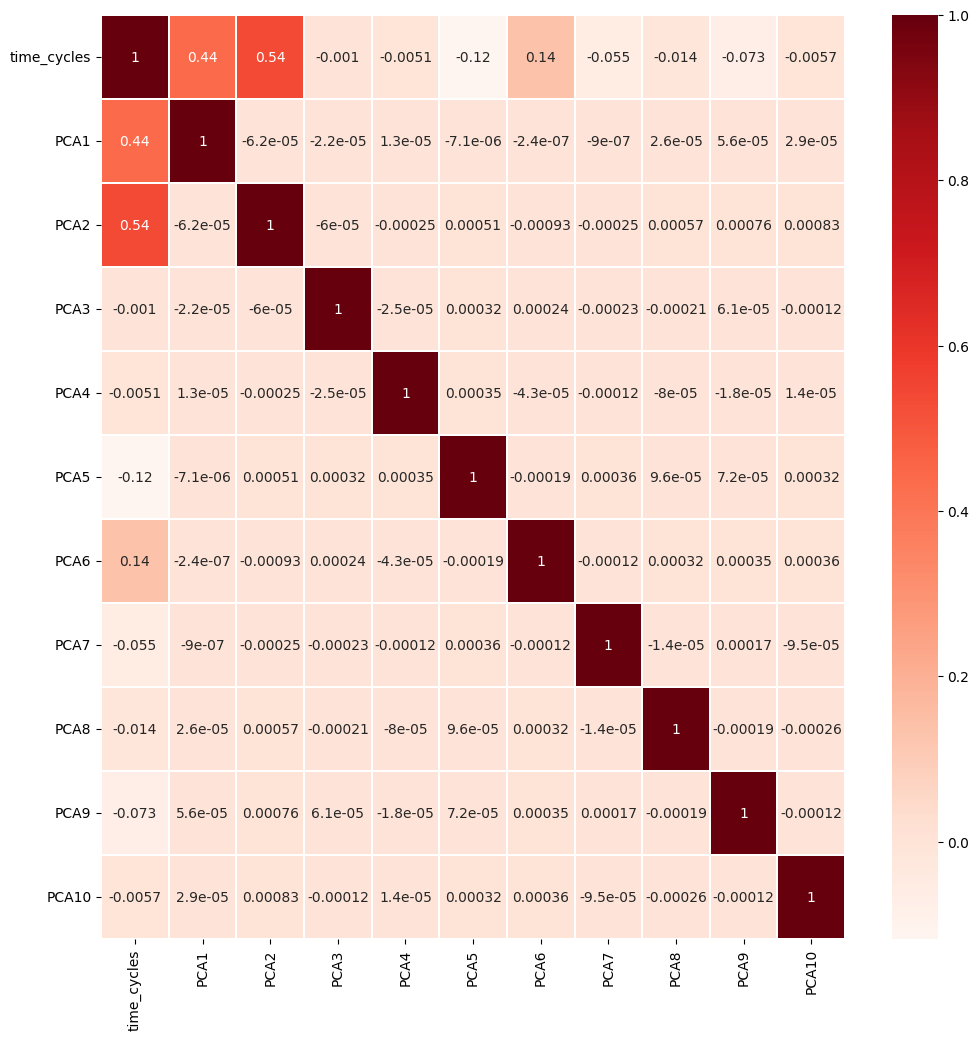

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="Reds", linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

##  Создание синтетических данных

### Предобработка данных

In [ ]:
train_processed = train[train.columns.tolist()[1:]]
train_processed = train_processed.loc[:20619]
train_processed = np.array(train_processed).reshape(1031, 20, 11)

In [ ]:
Rul_processed = tempRul['RUL'].values[:20620]
Rul_processed = np.array(Rul_processed).reshape(1031, 20)

In [ ]:
Rul_processed

array([[191, 190, 189, ..., 174, 173, 172],
       [171, 170, 169, ..., 154, 153, 152],
       [151, 150, 149, ..., 134, 133, 132],
       ...,
       [ 70,  69,  68, ...,  53,  52,  51],
       [ 50,  49,  48, ...,  33,  32,  31],
       [ 30,  29,  28, ...,  13,  12,  11]])

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Шкалирование

In [ ]:
scaler = tsgm.utils.TSFeatureWiseScaler((-1, 1))
train_processed = scaler.fit_transform(train_processed)

train_processed = train_processed.astype(np.float32)
y = Rul_processed.astype(np.float32)

In [ ]:
cols = train.columns.tolist()[1:]

Обучение модели генерации

In [ ]:
batch_size = 128

latent_dim = 12
feature_dim = train_processed.shape[-1]
seq_len = train_processed.shape[1]
output_dim = 1

generator_in_channels = latent_dim + output_dim
discriminator_in_channels = feature_dim + output_dim

In [ ]:
architecture = tsgm.models.architectures.zoo["t-cgan_c4"](
    seq_len=seq_len, feat_dim=feature_dim,
    latent_dim=latent_dim, output_dim=output_dim)
discriminator, generator = architecture.discriminator, architecture.generator


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_processed, y))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim,
    temporal=True,
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.2),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.2),
    loss_fn=keras.losses.MeanSquaredError(),
)

cond_gan.fit(dataset, epochs=500)

In [ ]:
X_gen = cond_gan.generate(y)
X_gen = X_gen.numpy()
y_gen = y

In [ ]:
X_gen.shape

(1031, 20, 11)

In [ ]:
data =  pd.DataFrame(train_processed.reshape(20620, 11), columns = train.columns.tolist()[1:])

In [ ]:
y = y.reshape(20620, 1)

In [ ]:
data.describe()

,time_cycles,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
count,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000
mean,-0.402981,-0.616037,-0.178397,-0.066545,-0.005222,-0.029753,-0.043900,-0.085544,-0.077272,-0.037172,-0.049163
std,0.381554,0.199909,0.296819,0.255748,0.238112,0.240044,0.242727,0.240651,0.238324,0.237495,0.254524
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.717452,-0.723127,-0.395667,-0.238739,-0.166361,-0.190361,-0.207092,-0.247992,-0.239035,-0.196049,-0.221879
50%,-0.429363,-0.658397,-0.197111,-0.067412,-0.004054,-0.028156,-0.046279,-0.084509,-0.078794,-0.038335,-0.046970
75%,-0.141274,-0.580134,0.003579,0.108091,0.154853,0.130362,0.118377,0.076250,0.085224,0.121853,0.124330
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
synthetic.describe()

,time_cycles,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
count,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000,20620.000000
mean,-0.377006,-0.663008,-0.253997,-0.036009,-0.039303,0.145796,-0.157839,-0.208608,-0.057468,0.018796,0.001803
std,0.470501,0.224909,0.416403,0.367547,0.347632,0.336938,0.381297,0.237931,0.342874,0.366390,0.336169
min,-0.999977,-0.999928,-0.998549,-0.954923,-0.996171,-0.701667,-0.985372,-0.984750,-0.976016,-0.993067,-0.976081
25%,-0.773142,-0.857280,-0.599837,-0.302076,-0.236112,-0.108991,-0.426528,-0.326680,-0.250082,-0.170625,-0.175917
50%,-0.469764,-0.681356,-0.242843,-0.065969,-0.023409,0.105076,-0.188040,-0.175203,-0.059949,-0.055263,-0.045212
75%,-0.067202,-0.501787,0.046498,0.202390,0.175015,0.393660,0.084385,-0.077384,0.140199,0.259333,0.124052
max,0.988744,0.403977,0.886611,0.984207,0.991773,0.979881,0.968306,0.658147,0.992067,0.947696,0.997600


In [ ]:
cols = train.columns.tolist()[1:]

In [ ]:
np.save( 'y.npy', y)

In [ ]:
synthetic.to_csv('NASA_12_PCA.csv')

In [ ]:
synthetic = pd.read_csv('/content/NASA_12_PCA.csv', index_col =0)

### Визуализация результатов

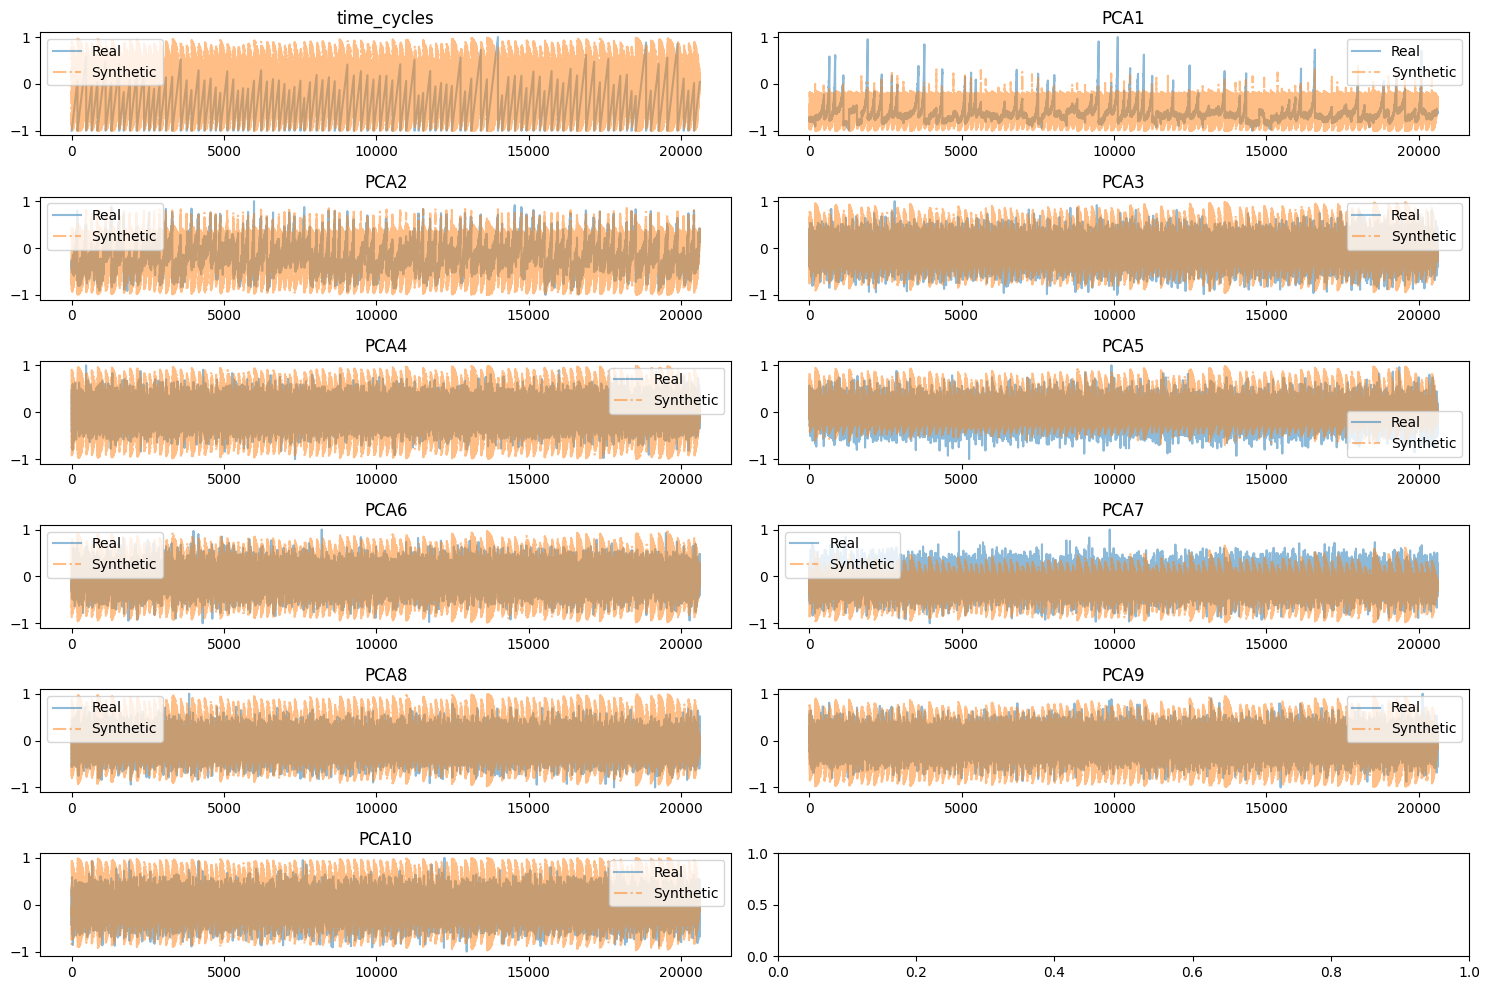

In [ ]:
# Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': data[col],
                   'Synthetic': synthetic[col]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '-.'], alpha=0.5)
fig.tight_layout()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(data))[:sample_size]

real_sample = np.asarray(synthetic)[idx]
synthetic_sample = np.asarray(synthetic)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = X_gen.reshape(-1, 20)
stock_data_reduced = np.asarray(X_gen).reshape(-1,20)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

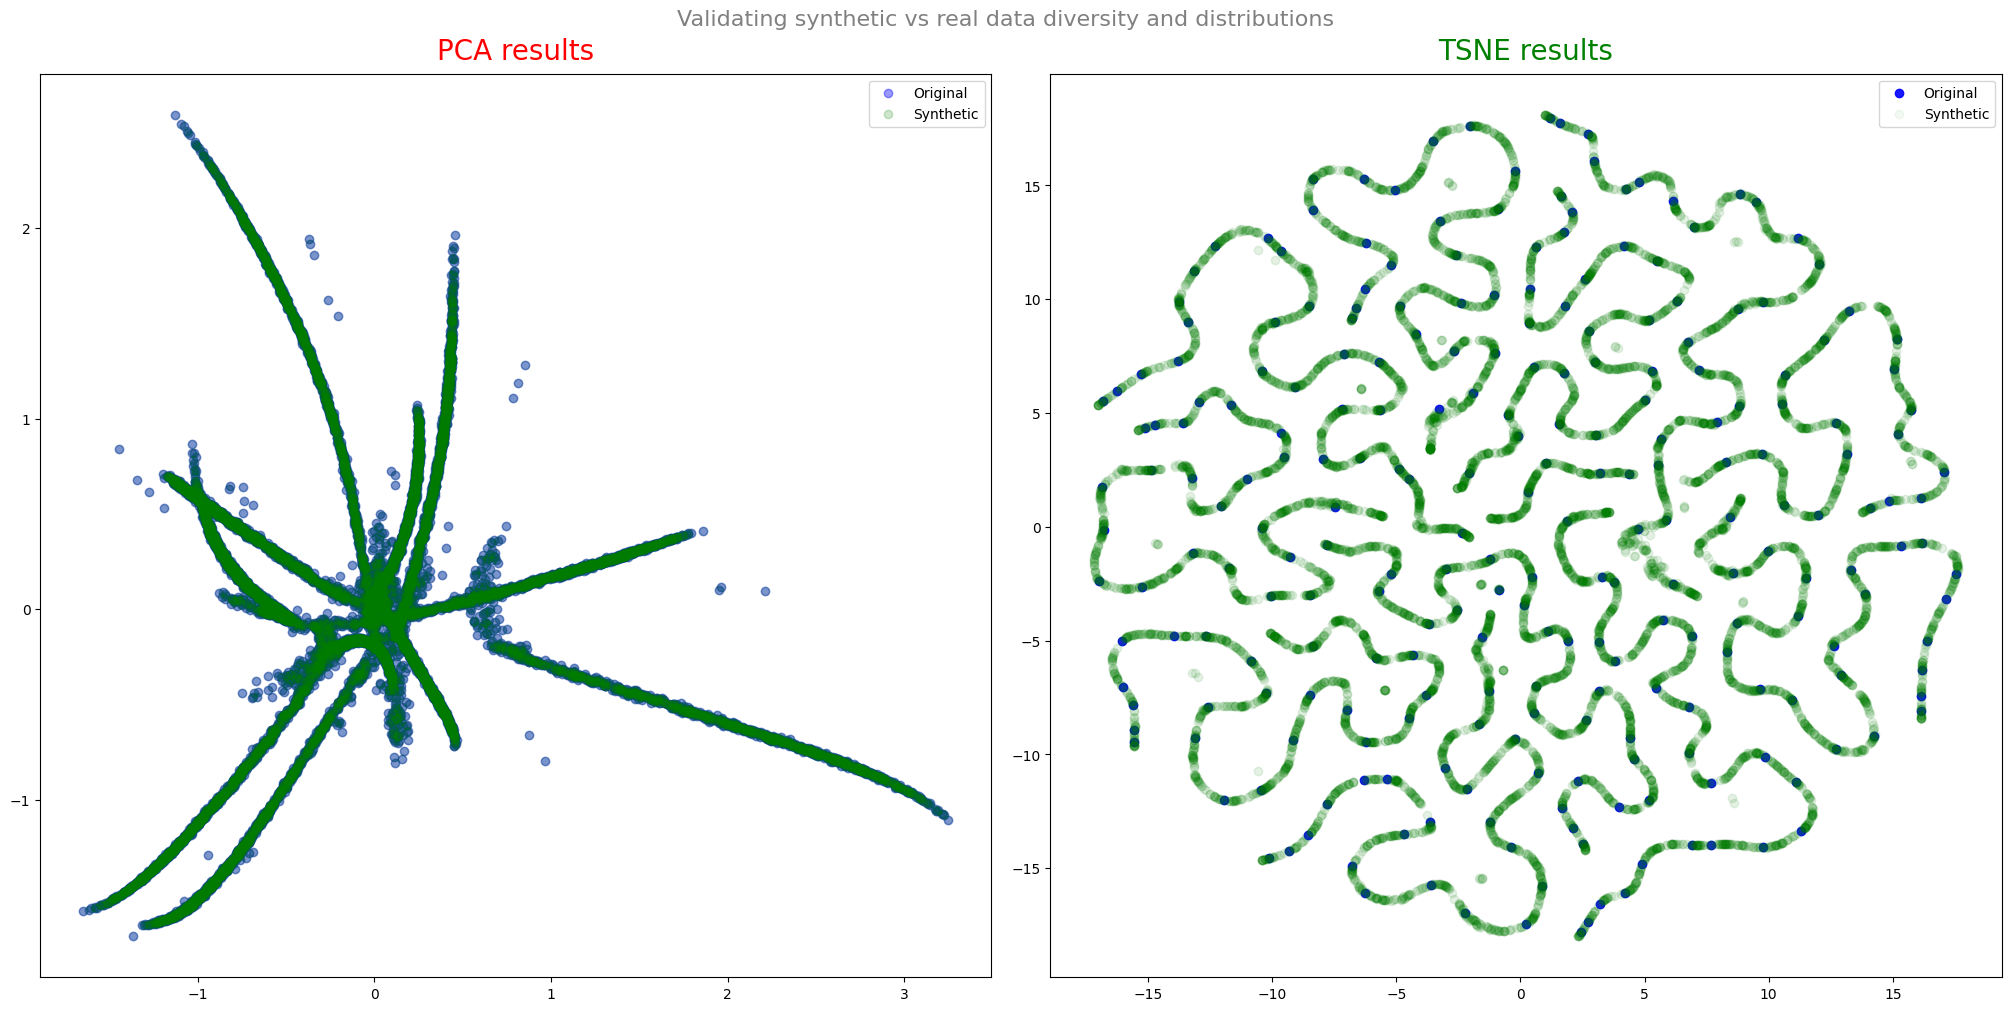

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='blue', alpha=0.4, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='green', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='green',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='blue', alpha=0.9, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='green', alpha=0.05, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

## Анализ синтетических данных

In [ ]:
pca_gen_data = pd.read_csv('/content/NASA_12_PCA.csv', index_col = 0)

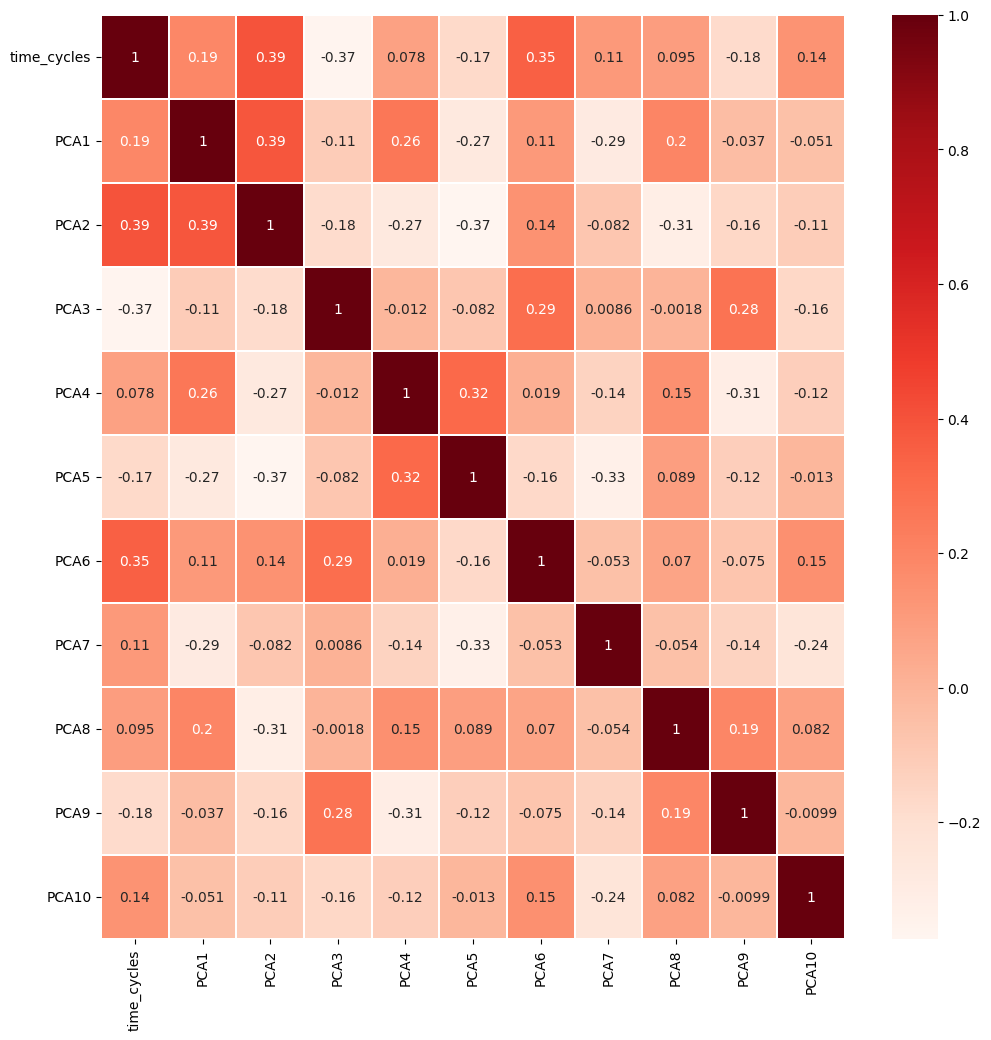

In [ ]:
sns.heatmap(pca_gen_data.corr(), annot=True, cmap="Reds", linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

## Оценка близости между реальными и синтетическими данными

In [ ]:
import numpy as np

def calc_euclidean(actual, predic):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(actual, predic):
    return np.mean(np.abs((actual - predic) / actual))

In [ ]:
eucl = []
mape = []
for col in data.columns.tolist():
  eucl.append(calc_euclidean(data[col], pca_gen_data[col]))
  mape.append(calc_mape(data[col], pca_gen_data[col]))

In [ ]:
print(np.mean(eucl), np.std(eucl))

58.52972596583154 7.5260934172642475


In [ ]:
print(np.mean(mape), np.std(mape))

9.815453121826998 4.593820860582462


## Обучение регрессора на реальных и синтетических данных

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#синтетические данные
X_train_gen, X_test_gen, y_train, y_test = train_test_split(pca_gen_data, tempRul['RUL'].values[:20620], random_state = 44)

In [ ]:
#реальные данные
X_train, X_test, y_train, y_test = train_test_split(data, tempRul['RUL'].values[:20620], random_state = 44)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, mean_absolute_error

### Обучение алгоритма линейной регрессии

In [ ]:
from sklearn.linear_model import LinearRegression
classifier_gen = LinearRegression()
classifier_gen.fit(X_train_gen, y_train)

LinearRegression()

In [ ]:
preds = classifier_gen.predict(X_test_gen)

In [ ]:
rmse = np.sqrt(mse(y_test, preds))
print(rmse)
r2_sc = r2_score(y_test, preds)
print(r2_sc)

31.598471675519455
0.7940989453714529


In [ ]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [ ]:
preds = classifier.predict(X_test)

In [ ]:
rmse = np.sqrt(mse(y_test, preds))
print(rmse)
r2_sc = r2_score(y_test, preds)
print(r2_sc)

40.96495382779554
0.6539400383625191


### Обучение алгоритма решающего дерева

In [ ]:
from sklearn.tree import DecisionTreeRegressor
classifier = DecisionTreeRegressor()
classifier.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
preds = classifier.predict(X_test)

In [ ]:
rmse = np.sqrt(mse(y_test, preds))
print(rmse)
r2_sc = r2_score(y_test, preds)
print(r2_sc)
mae = mean_absolute_error(y_test, preds_gen)
print(mae)

52.020476457852986
0.4419474758538974
36.459057


In [ ]:
classifier_gen = DecisionTreeRegressor()
classifier_gen.fit(X_train_gen, y_train)

DecisionTreeRegressor()

In [ ]:
preds = classifier_gen.predict(X_test)

In [ ]:
rmse = np.sqrt(mse(y_test, preds))
print(rmse)
r2_sc = r2_score(y_test, preds)
print(r2_sc)
mae = mean_absolute_error(y_test, preds_gen)
print(mae)

53.419972870218665
0.41151724305580806
36.45905682153776


### Обучение алгоритма XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
cls_synth = XGBRegressor()

In [ ]:
cls_synth.fit(X_train_gen, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds_gen = cls_synth.predict(X_test)

In [ ]:
rmse_gen = np.sqrt(mse(y_test, preds_gen))
print(rmse_gen)
r2_sc_gen = r2_score(y_test, preds_gen)
print(r2_sc_gen)
mae = mean_absolute_error(y_test, preds_gen)
print(mae)

51.52221
0.4525866988501621
36.459057


Анализ метрик после удаления одного из признаков выборки

In [ ]:
rmse = []
r2_sc = []
mae = []
for col in pca_gen_data.columns.tolist():
  print(col)
  train_data = pca_gen_data.drop([col], axis = 1)
  test_data = X_test.drop([col], axis = 1)
  X_train_gen, X_test_gen, y_train, y_test = train_test_split(train_data, tempRul['RUL'].values[:20620], random_state = 44)
  cls_synth = XGBRegressor()
  cls_synth.fit(X_train_gen, y_train)
  preds_gen = cls_synth.predict(test_data)
  rmse_gen = np.sqrt(mse(y_test, preds_gen))
  print(rmse_gen)
  r2_sc_gen = r2_score(y_test, preds_gen)
  print(r2_sc_gen)
  mae_gen = mean_absolute_error(y_test, preds_gen)
  print(mae_gen)
  rmse.append(rmse_gen)
  r2_sc.append(r2_sc_gen)
  mae.append(mae_gen)

time_cycles
62.361413311456644
0.19802964609317486
45.65710194889315
PCA1
49.42336511325946
0.49627785957385195
35.867447107680555
PCA2
56.482170756980835
0.34211622652179396
41.50382773044847
PCA3
50.91865311219168
0.46533687740180285
35.86634038347899
PCA4
50.999030917348094
0.46364755669653024
35.80368625963925
PCA5
50.38253409089703
0.4765364685114517
35.789788085678964
PCA6
51.223627835095186
0.45891302116300847
36.21773114240828
PCA7
51.085522234257255
0.46182677047740706
35.97716850297296
PCA8
50.660395583130324
0.47074670653915784
35.797331814712166
PCA9
51.241342551904495
0.458538707181964
36.30402249787599
PCA10
53.38371738475054
0.4123157641611992
37.519805488386396


In [ ]:
pca_gen_data.columns.tolist()

['time_cycles',
 'PCA1',
 'PCA2',
 'PCA3',
 'PCA4',
 'PCA5',
 'PCA6',
 'PCA7',
 'PCA8',
 'PCA9',
 'PCA10']

In [ ]:
result = pd.DataFrame([pca_gen_data.columns.tolist(), mae, rmse, r2_sc]).T
result.columns = ['Deleted column', 'Mean absolute error', 'Root mean squared error', 'R2 score']
result

,Deleted column,Mean absolute error,Root mean squared error,R2 score
0,time_cycles,45.657102,62.361413,0.19803
1,PCA1,35.867447,49.423365,0.496278
2,PCA2,41.503828,56.482171,0.342116
3,PCA3,35.86634,50.918653,0.465337
4,PCA4,35.803686,50.999031,0.463648
5,PCA5,35.789788,50.382534,0.476536
6,PCA6,36.217731,51.223628,0.458913
7,PCA7,35.977169,51.085522,0.461827
8,PCA8,35.797332,50.660396,0.470747
9,PCA9,36.304022,51.241343,0.458539


In [ ]:
#регрессор для обучения на реальных данных
cls = XGBRegressor()

In [ ]:
cls.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds = cls.predict(X_test)

In [ ]:
rmse = np.sqrt(mse(y_test, preds))
print(rmse)
r2_sc = r2_score(y_test, preds)
print(r2_sc)
mae = mean_absolute_error(y_test, preds_gen)
print(mae)

38.066082
0.701184743185363
36.459057


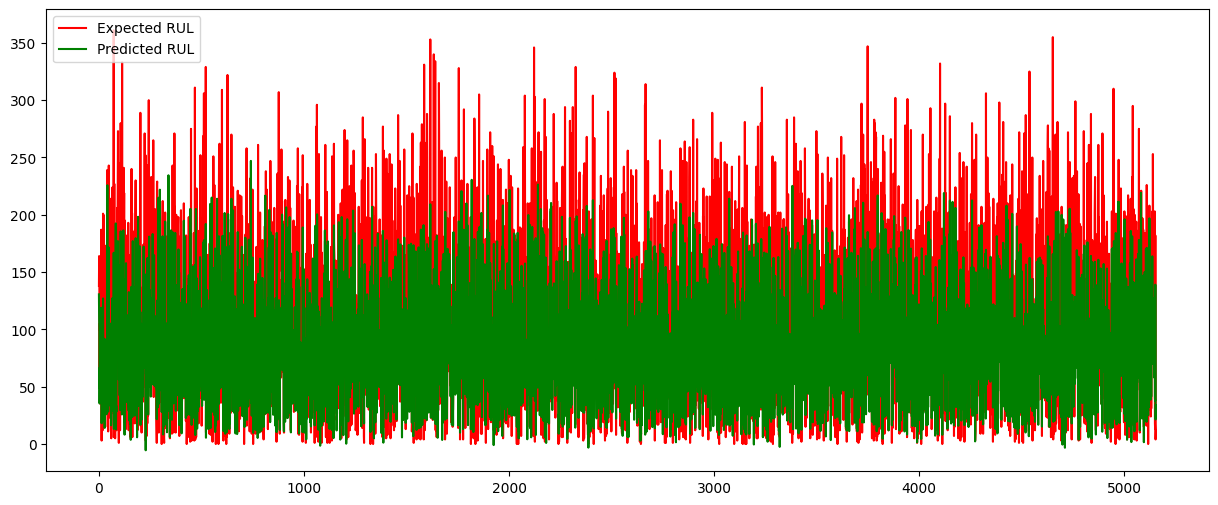

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(y_test, label = "Expected RUL", color = "Red")
plt.plot(preds_gen, label = "Predicted RUL", color = "Green")
plt.legend(loc = 'upper left')
plt.show()

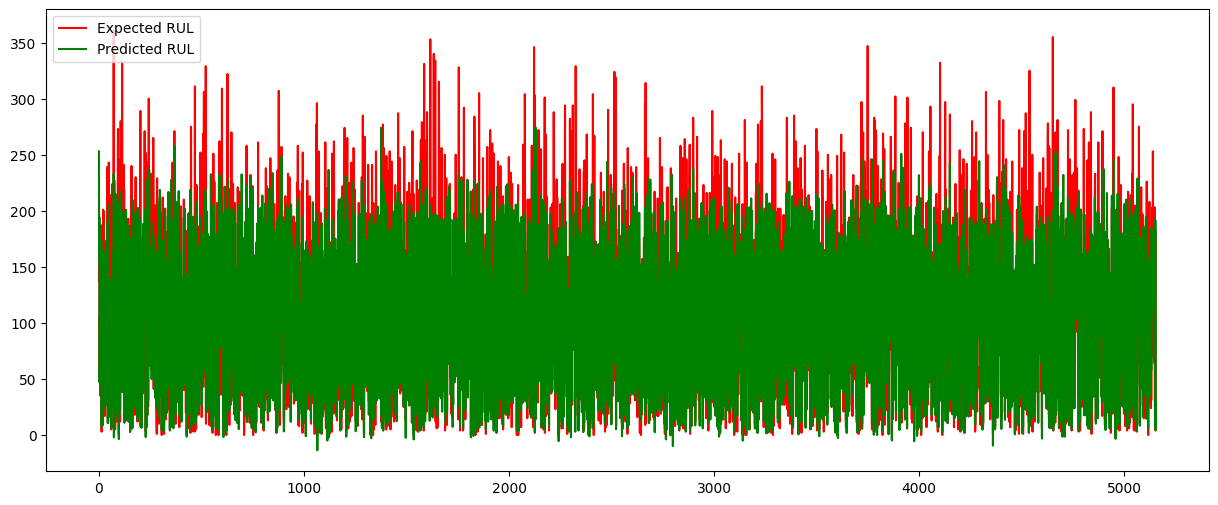

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(y_test, label = "Expected RUL", color = "Red")
plt.plot(preds, label = "Predicted RUL", color = "Green")
plt.legend(loc = 'upper left')
plt.show()

Анализ важности признаков

In [ ]:
X_train_gen, X_test_gen, y_train, y_test = train_test_split(synthetic, y, random_state = 44)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state = 44)

In [ ]:
cls_synth = XGBRegressor()

In [ ]:
cls_synth.fit(X_train_gen, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Xgboost Feature Importance')

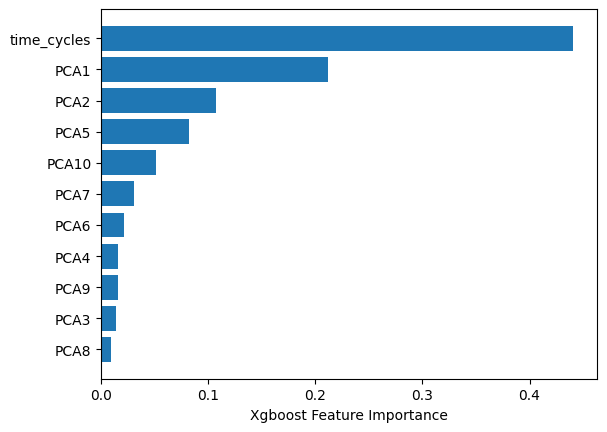

In [ ]:
sorted_idx = cls_synth.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], cls_synth.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

# Fit model using each importance as a threshold
thresholds = sort(cls_synth.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(cls_synth, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train_gen)
 # train model
 selection_model = XGBRegressor()
 selection_model.fit(select_X_train, y_train);
 # eval model
 select_X_test = selection.transform(X_test)
 y_pred = selection_model.predict(select_X_test)
 predictions = [round(value) for value in y_pred]
 mae = mean_absolute_error(y_test, predictions)
 print("Thresh=%.3f, n=%d, MAE score: %.2f" % (thresh, select_X_train.shape[1], mae))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=11, MAE score: 36.46


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.014, n=10, MAE score: 35.80


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.016, n=9, MAE score: 36.43


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.016, n=8, MAE score: 35.84


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.021, n=7, MAE score: 35.92


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.031, n=6, MAE score: 35.29


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.051, n=5, MAE score: 35.19
Thresh=0.082, n=4, MAE score: 36.84


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.107, n=3, MAE score: 36.36
Thresh=0.212, n=2, MAE score: 42.30
Thresh=0.441, n=1, MAE score: 34.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
cls = XGBRegressor()
cls.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Xgboost Feature Importance for real data')

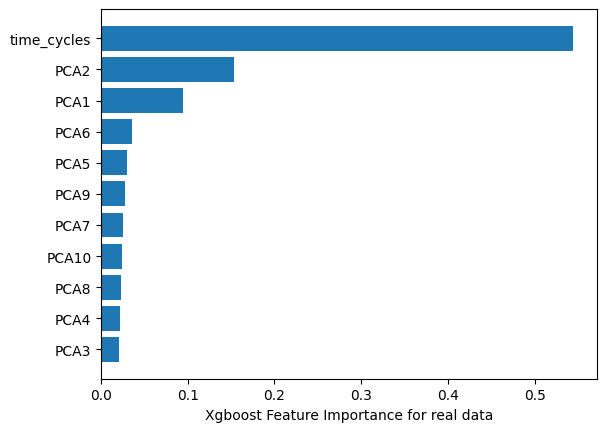

In [ ]:
cls.fit(X_train, y_train)
sorted_idx =  cls.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], cls.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance for real data")

In [ ]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

# Fit model using each importance as a threshold
thresholds = sort(cls.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(cls, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train)
 # train model
 selection_model = XGBRegressor()
 selection_model.fit(select_X_train, y_train)
 # eval model
 select_X_test = selection.transform(X_test)
 y_pred = selection_model.predict(select_X_test)
 predictions = [round(value) for value in y_pred]
 mae = mean_absolute_error(y_test, predictions)
 print("Thresh=%.3f, n=%d, MAE score: %.2f" % (thresh, select_X_train.shape[1],mae))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.021, n=11, MAE score: 27.07


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.021, n=10, MAE score: 27.07


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.023, n=9, MAE score: 27.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.024, n=8, MAE score: 27.06


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.025, n=7, MAE score: 27.01


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.028, n=6, MAE score: 26.99


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.030, n=5, MAE score: 26.74


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.035, n=4, MAE score: 27.37
Thresh=0.094, n=3, MAE score: 27.75
Thresh=0.154, n=2, MAE score: 30.74
Thresh=0.545, n=1, MAE score: 34.17


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
